# Lysostaphin vs Staphylococcus aureus

AF3 modelling of lysostaphin (catalytic and cell wall binding domain) in complex with peptidoglycan fragments from S. aureus.

PG library generated with [PGN_MS2](https://github.com/jerickwan/PGN_MS2).

In [95]:
from copy import deepcopy
import json
import os
from pathlib import Path
import random
import re
import subprocess
import tempfile

from Bio import SeqIO
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import display

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

from src.pg_modelling.ligand_utils import generate_ccd_from_smiles, sanitize_ligand_name, gen_model_seeds

In [2]:
data_folder = Path(os.path.expanduser('~')) / 'Documents' / 'PG_modelling'
assert data_folder.is_dir()

## Generate possible bridges

In [3]:
canonical = 'Gly>Gly>Gly>Gly>Gly'  # pentaglycine
smaller_bridges = [
    'Gly>Gly>Gly>Gly',
    'Gly>Gly>Gly',
    'Gly>Gly',
    'Gly',
]
ala_bridges = [
    'Ala>Gly>Gly>Gly>Gly',
    'Gly>Ala>Gly>Gly>Gly',
    'Gly>Gly>Ala>Gly>Gly',
    'Gly>Gly>Gly>Ala>Gly',
    'Gly>Gly>Gly>Gly>Ala',
]
ser_bridges = [
    'Ser>Gly>Gly>Gly>Gly',
    'Gly>Ser>Gly>Gly>Gly',
    'Gly>Gly>Ser>Gly>Gly',
    'Gly>Gly>Gly>Ser>Gly',
    'Gly>Gly>Gly>Gly>Ser',
]
','.join([canonical] + smaller_bridges + ala_bridges + ser_bridges)

'Gly>Gly>Gly>Gly>Gly,Gly>Gly>Gly>Gly,Gly>Gly>Gly,Gly>Gly,Gly,Ala>Gly>Gly>Gly>Gly,Gly>Ala>Gly>Gly>Gly,Gly>Gly>Ala>Gly>Gly,Gly>Gly>Gly>Ala>Gly,Gly>Gly>Gly>Gly>Ala,Ser>Gly>Gly>Gly>Gly,Gly>Ser>Gly>Gly>Gly,Gly>Gly>Ser>Gly>Gly,Gly>Gly>Gly>Ser>Gly,Gly>Gly>Gly>Gly>Ser'

## Load Lysostaphin

In [4]:
lysostaphin_path = data_folder / 'S_aureus' / 'S_aureus_lysostaphin.fasta'
lysostaphin_records = SeqIO.to_dict(SeqIO.parse(lysostaphin_path, 'fasta'))

In [96]:
lysostaphin_peptidase_m23 = {
    'protein': {
        'id': 'A',
        'sequence': str(lysostaphin_records['Lysostaphin_P10547_Peptiase_M23_279_364'].seq).upper()
    },
}
lysostaphin_sh3b = {
    'protein': {
        'id': 'A',
        'sequence': str(lysostaphin_records['Lysostaphin_P10547_SH3b_413_481'].seq).upper()
    },
}
lysostaphin_sh3b_2 = deepcopy(lysostaphin_sh3b)
lysostaphin_sh3b_2['protein']['id'] = ['A', 'C']

## Load PG fragments

In [11]:
pgn_df = pd.read_csv(data_folder / 'S_aureus' / 'S_aureus_fragments_1mer.csv')
print(f'Number of fragments: {len(pgn_df):,}')
pgn_df.head()

Number of fragments: 195


,Name,Synonym,Formula,Monoisotopic Mass,Modifications,Degree Amidation,Degree Acetylation,Ontology,PGN Units,Glycan Units,...,Peptide,SMILES,INCHIKEY,clogP,RT,[M+H]+,[M+Na]+,[M+K]+,[M+2H]2+,[M+3H]3+
0,None-K[3-NH2-GGGGA],None--Lys[3--NH2--Gly.Gly.Gly.Gly.Ala],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GGGGA],CC(N)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(N...,SZYLKPZPDXMNKU-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678
1,None-AqK[3-NH2-GGGGA],None--Ala.γ-isoGln.Lys[3--NH2--Gly.Gly.Gly.Gly...,C25H44N10O10,644.32419,Amidase,1,0,P3--S5,1,0,...,AqK[3-NH2-GGGGA],CC(N)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(N...,RBKYMGGPVJWHMK-UHFFFAOYSA-N,-6.2482,0,645.33147,667.31341,683.28735,323.16938,215.78201
2,None-K[3-NH2-GGGAG],None--Lys[3--NH2--Gly.Gly.Gly.Ala.Gly],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GGGAG],CC(NC(=O)CN)C(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(N...,SOOQFNIYIPGCLP-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678
3,None-K[3-NH2-GGAGG],None--Lys[3--NH2--Gly.Gly.Ala.Gly.Gly],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GGAGG],CC(NC(=O)CNC(=O)CN)C(=O)NCC(=O)NCC(=O)NCCCCC(N...,QTPFCZZQBOJGEK-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678
4,None-K[3-NH2-GAGGG],None--Lys[3--NH2--Gly.Ala.Gly.Gly.Gly],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GAGGG],CC(NC(=O)CNC(=O)CNC(=O)CN)C(=O)NCC(=O)NCCCCC(N...,TVCZZGTWYXQCDJ-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678


Sub-select entries without glycans but with stem + bridge, or stem alone or bridge alone (including Lys residue from stem).

In [99]:
pgn_subset = pgn_df[
    (pgn_df['Glycan Units'] == 0) &
    (
        pgn_df['Peptide Units'].isin([4, 5]) &
        (pgn_df['Modifications'] == 'Amidase')
    ) |
    (
        pgn_df['Peptide Units'].isin([3, 4]) &
        (pgn_df['Modifications'] == 'EPase P2')
    )
]
print(f'Number of fragments in subset: {len(pgn_subset):,}')

Number of fragments in subset: 61


## Cleaving peptide bridge from sidechain

CC(NC(=O)C(N)CCCCNC(=O)CNC(=O)CNC(=O)C(CO)NC(=O)CNC(=O)CN)C(=O)O


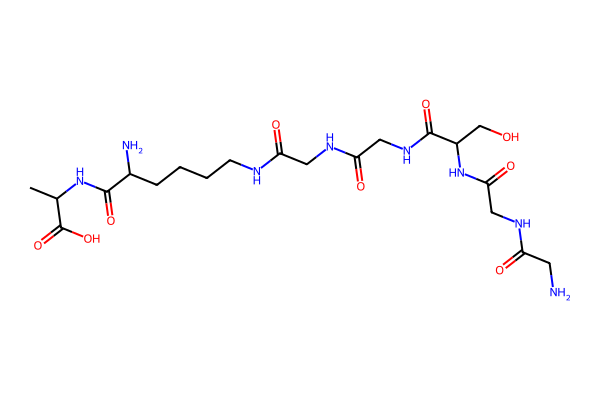

In [87]:
smiles = pgn_subset[pgn_subset['Name'] == 'None-KA[3-NH2-GGSGG]'].iloc[0]['SMILES']

print(smiles)

mol = Chem.MolFromSmiles(smiles)

img = Chem.Draw.MolToImage(mol, size=(600, 400), dpi=300)
display(img)

NCC(=O)NCC(=O)NC(CO)C(=O)NCC(=O)NCC=O


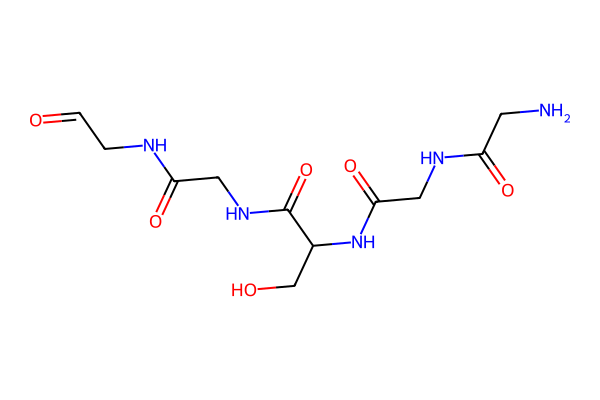

In [ ]:
# This SMARTS looks for:
#  [C;X4][C;X4][C;X4][C;X4][N:1] - [C:2](=O) - [*:3]
# and breaks the single bond between N:1 and C:2, yielding:
#  [C;X4][C;X4][C;X4][C;X4][N:1]   +   [C:2](=O)[*:3]
rxn_smarts = """
[C;X4][C;X4][C;X4][C;X4][N:1]-[C:2](=O)-[*:3]>>[C;X4][C;X4][C;X4][C;X4][N:1].[C:2](=O)-[*:3]
"""
rxn = AllChem.ReactionFromSmarts(rxn_smarts)

def cleave_lys_amide(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    products_sets = rxn.RunReactants((mol,))
    if len(products_sets) == 0:
        return None

    # We'll assume we only get one relevant product set for a single Lys site
    out = []
    for product_mol in products_sets[0]:
        smi = Chem.MolToSmiles(product_mol, canonical=True, isomericSmiles=True)
        out.append(smi)
    
    return out[1]

res = cleave_lys_amide(smiles)
print(res)

res_mol = Chem.MolFromSmiles(res)

img = Chem.Draw.MolToImage(res_mol, size=(600, 400), dpi=300)
display(img)

In [101]:
bridges = set()
for _, row in pgn_subset.iterrows():
    bridge = cleave_lys_amide(row['SMILES'])
    if bridge is not None:
        bridges.add(bridge)

print(f'Number of bridges: {len(bridges)}')
bridges

Number of bridges: 16


{'CC(C=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CN',
 'CC(N)C(=O)NC(CCC=O)C(N)=O',
 'CC(N)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC=O',
 'CC(NC(=O)CN)C(=O)NCC(=O)NCC(=O)NCC=O',
 'CC(NC(=O)CNC(=O)CN)C(=O)NCC(=O)NCC=O',
 'CC(NC(=O)CNC(=O)CNC(=O)CN)C(=O)NCC=O',
 'NC(CO)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC=O',
 'NCC(=O)NC(CO)C(=O)NCC(=O)NCC(=O)NCC=O',
 'NCC(=O)NCC(=O)NC(CO)C(=O)NCC(=O)NCC=O',
 'NCC(=O)NCC(=O)NCC(=O)NC(CO)C(=O)NCC=O',
 'NCC(=O)NCC(=O)NCC(=O)NCC(=O)NC(C=O)CO',
 'NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC=O',
 'NCC(=O)NCC(=O)NCC(=O)NCC=O',
 'NCC(=O)NCC(=O)NCC=O',
 'NCC(=O)NCC=O',
 'NCC=O'}

## Generate AF3 inputs

In [30]:
zn_ion_seq = {
    'ligand': {
        'id': 'C',
        'smiles': '[Zn+2]',
    }
}

In [102]:
for bridge_only in [False, True]:
    seen_bridges = set()
    lysostaphin_domains = [
        ('M23', lysostaphin_peptidase_m23, [zn_ion_seq]),
        ('SH3b', lysostaphin_sh3b, []),
    ]
    for _, row in pgn_subset.iterrows():
        raw_name = row['Name']
        ligand_name = sanitize_ligand_name(raw_name)
        
        smiles = row['SMILES']

        if bridge_only:
            bridge = cleave_lys_amide(smiles)
            if bridge is not None and bridge not in seen_bridges:
                smiles = bridge
                seen_bridges.add(bridge)

                ligand_name = re.match(r'^.+\[3-NH2-([^\[\]]+)\]$', raw_name)[1]
            else:
                continue

        ccd_code = f'LIG-PG-{ligand_name}'.replace('_', '-')
        ligand_seq = {
            'ligand': {
                'id': 'B',
                'ccdCodes': [ccd_code],
            }
        }
        try:
            ccd_data = generate_ccd_from_smiles(smiles, ccd_code)
        except ValueError:
            print(f'Error for ligand: {raw_name}')
            raise

        for domain_name, domain_seq, ions_seq in lysostaphin_domains:
            name = f'Lysostaphin_{domain_name}_vs_{ligand_name}'

            sequences = [
                domain_seq,
                ligand_seq,
            ]
            sequences += ions_seq

            data = {
                'name': name,
                'sequences': sequences,
                'userCCD': ccd_data,
                'modelSeeds': gen_model_seeds(3),
                'dialect': 'alphafold3',
                'version': 1,
            }
            with (data_folder / 'S_aureus' / 'AF3_inputs' / f'{name}.json').open('w') as f_out:
                json.dump(
                    data, 
                    f_out,
                    indent=True,
                )

[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling AddHs()
[00:20:12] Molecule does not have explicit Hs. Consider calling 

Also add canonical PG + 2 x SH3b to see if we can reproduce results from [Gonzalez-Delgado et al., 2019](https://www.nature.com/articles/s41589-019-0393-4).

In [33]:
canonical_name = 'None-AqKAA[3-NH2-GGGGG]'
canonical_row = pgn_subset[pgn_subset['Name'] == canonical_name].iloc[0]
raw_name = row['Name']
ligand_name = sanitize_ligand_name(raw_name)
smiles = row['SMILES']
ccd_code = f'LIG-PG-{ligand_name}'.replace('_', '-')
ligand_seq = {
    'ligand': {
        'id': 'B',
        'ccdCodes': [ccd_code],
    }
}
ccd_data = generate_ccd_from_smiles(smiles, ccd_code)
name = f'Lysostaphin_SH3b_x2_vs_{ligand_name}'
sequences = [
    lysostaphin_sh3b_2,
    ligand_seq,
]

data = {
    'name': name,
    'sequences': sequences,
    'userCCD': ccd_data,
    'modelSeeds': gen_model_seeds(3),
    'dialect': 'alphafold3',
    'version': 1,
}
with (data_folder / 'S_aureus' / 'AF3_inputs' / f'{name}.json').open('w') as f_out:
    json.dump(
        data, 
        f_out,
        indent=True,
    )

[22:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
[22:15:22] Molecule does not have explicit Hs. Consider calling AddHs()
